In [1]:
import numpy as np
from scipy import interpolate
from scipy.integrate import dblquad
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

np.set_printoptions(formatter={'float': lambda x: "{0:0.8f}".format(x)})
%matplotlib notebook

# Lanczos Filter

In [2]:
def filter(x, a):
    return np.piecewise(x, [abs(x) < a], [lambda x: np.sinc(x) * np.sinc(x / a)])

In [83]:
filter(np.array([0,2.5,4.0, -4]),3)

array([1.00000000, 0.02431708, 0.00000000, 0.00000000])

<IPython.core.display.Javascript object>


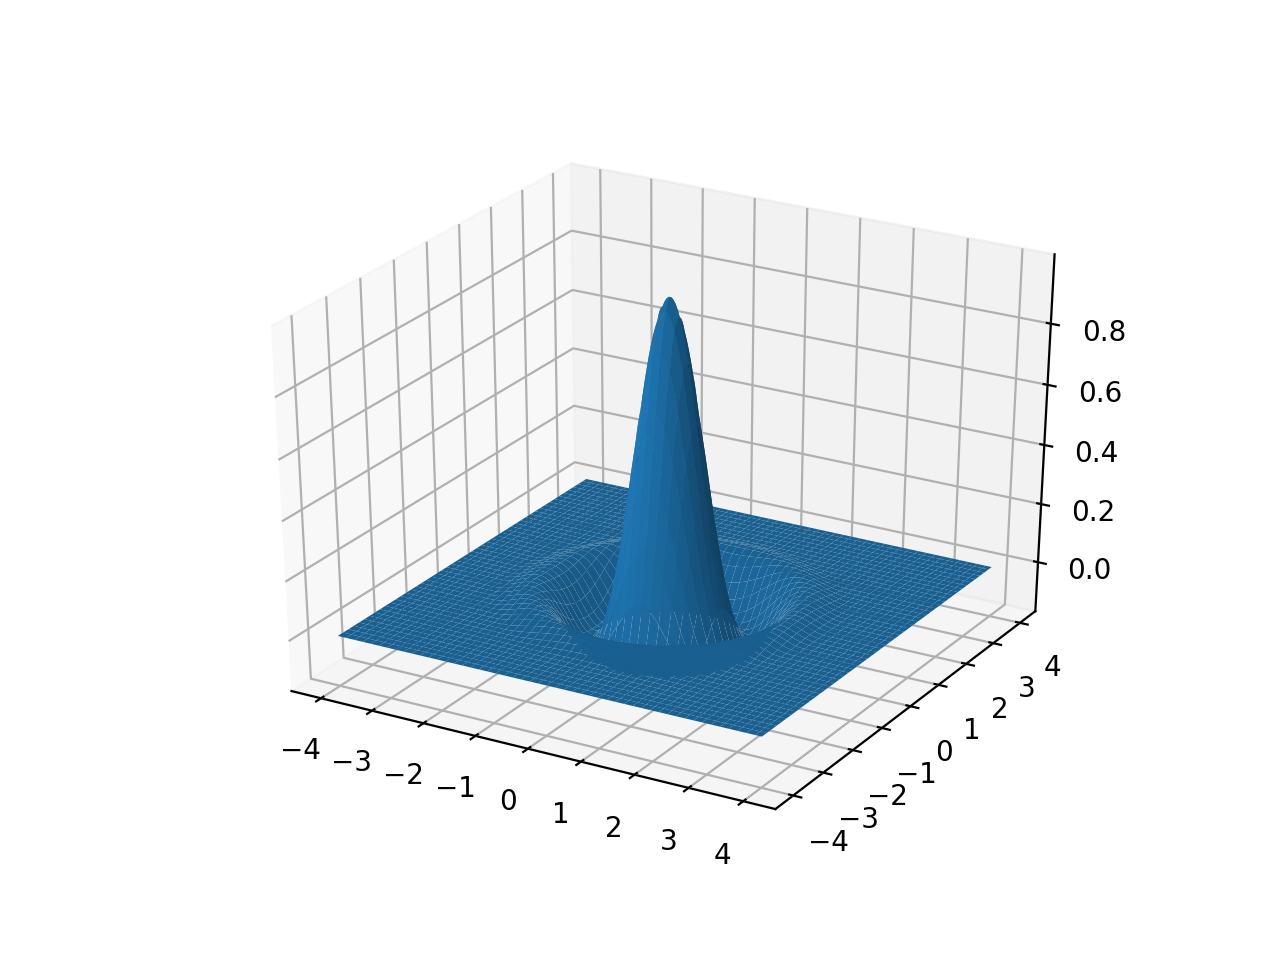

In [84]:
x = np.linspace(-4, 4, 200)
y = np.linspace(-4, 4, 200)

(x, y) = np.meshgrid(x, y)
z = filter(np.sqrt(x*x+y*y), 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z)
plt.show()

# Least Squares Spline Interpolation

In [5]:
x = np.linspace(-4, 4, 200)
y = np.linspace(-4, 4, 200)
(x, y) = np.meshgrid(x, y)
z = filter(np.sqrt(x*x+y*y), 3)
x = x.flatten();
y = y.flatten();
z = z.flatten();

degree = 5
knots = np.linspace(-3, 3, 7)
spline = interpolate.LSQBivariateSpline(x, y, z, knots, knots, kx = degree, ky = degree)

(integral, integral_err) = dblquad(lambda x, y: spline.ev(y,x), -4, 4, lambda x: -3, lambda x: 3)
normalization = 1./integral

In [6]:
spline.get_knots()

(array([-4.00000000, -4.00000000, -4.00000000, -4.00000000, -4.00000000,
        -4.00000000, -3.00000000, -2.00000000, -1.00000000, 0.00000000,
        1.00000000, 2.00000000, 3.00000000, 4.00000000, 4.00000000,
        4.00000000, 4.00000000, 4.00000000, 4.00000000]),
 array([-4.00000000, -4.00000000, -4.00000000, -4.00000000, -4.00000000,
        -4.00000000, -3.00000000, -2.00000000, -1.00000000, 0.00000000,
        1.00000000, 2.00000000, 3.00000000, 4.00000000, 4.00000000,
        4.00000000, 4.00000000, 4.00000000, 4.00000000]))

In [7]:
xnew = np.linspace(-3, 3, 100)
ynew = np.linspace(-3, 3, 100)

(x_spline, y_spline) = np.meshgrid(xnew, ynew)
z_spline = spline.ev(x_spline, y_spline)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_spline, y_spline, z_spline)
plt.show()

<IPython.core.display.Javascript object>

In [8]:
spline.get_coeffs()

array([-0.00018153, 0.00087153, -0.00266214, 0.00697876, -0.01601655,
       0.02854232, 0.00311595, 0.02854232, -0.01601655, 0.00697876,
       -0.00266214, 0.00087153, -0.00018153, 0.00087153, -0.00400824,
       0.01166987, -0.02921079, 0.06456646, -0.11147457, -0.01819097,
       -0.11147457, 0.06456646, -0.02921079, 0.01166987, -0.00400824,
       0.00087153, -0.00266214, 0.01166987, -0.03202329, 0.07521402,
       -0.15692202, 0.25649697, 0.07034190, 0.25649697, -0.15692202,
       0.07521402, -0.03202329, 0.01166987, -0.00266214, 0.00697876,
       -0.02921079, 0.07521402, -0.16332107, 0.31344868, -0.46471588,
       -0.24938464, -0.46471588, 0.31344868, -0.16332107, 0.07521402,
       -0.02921079, 0.00697876, -0.01601655, 0.06456646, -0.15692202,
       0.31344868, -0.53800687, 0.65991479, 0.83435786, 0.65991479,
       -0.53800687, 0.31344868, -0.15692202, 0.06456646, -0.01601655,
       0.02854232, -0.11147457, 0.25649697, -0.46471588, 0.65991479,
       -0.39631831, -2.25139

# Symbolic Math Engine

In [13]:
import collections
   
class Multinomial:
    def __init__(self, factor = 0, powers = None, symbols = None):
        self.factor = factor
        if powers is None:
            self.powers = []
        else:
            self.powers = powers
        if symbols is None:
            self.symbols = []
        else:
            self.symbols = symbols
            
        self.clean()

    @classmethod
    def single(cls, factor, power, sym):
        return cls(factor, [power], [sym])
    
    @classmethod
    def num(cls, num):
        return cls(num, [], [])

    def __eq__(self, other):
        if type(other) is Multinomial:
            return self.factor == other.factor and self.equal_powers(other)
        if other == 0:
            try:
                if self.factor == 0:
                    return True
                else:
                    return False
            except ValueError:
                return False
        return NotImplemented
    
    def __add__(self, other):
        self.clean()
        powers_copy = [x for x in self.powers]
        symbols_copy = [x for x in self.symbols]
        if type(other) is float or type(other) is int:
            other = Multinomial.num(other)
        if type(other) is not Multinomial:
            return NotImplemented
        if self.equal_powers(other):
            return Multinomial(self.factor + other.factor, powers_copy, symbols_copy)
        else:
            poly = Polynomial()
            poly += self
            poly += other
            return poly
        
    def __neg__(self):
        powers_copy = [x for x in self.powers]
        symbols_copy = [x for x in self.symbols]
        result = Multinomial(-self.factor, powers_copy, symbols_copy)
        return result
    
    def __mul__(self, other):
        if type(other) is Multinomial:
            result = Multinomial(self.factor * other.factor, [], [])
            for i, sym in enumerate(self.symbols):
                result.symbols.append(sym)
                result.powers.append(self.powers[i])
                if sym in other.symbols:
                    index = other.symbols.index(sym)
                    result.powers[-1] += other.powers[index]
                
            remaining_symbols = [x for x in other.symbols if x not in self.symbols]
            for sym in remaining_symbols:
                index = other.symbols.index(sym)
                result.symbols.append(sym)
                result.powers.append(other.powers[index])
            return result
            
        if type(other) is Polynomial:
            poly = Polynomial()
            for x in other:
                poly += self * x
            return poly
        if type(other) is Piece:
            return NotImplemented
        if type(other) is Piecewise:
            return NotImplemented
        powers_copy = [x for x in self.powers]
        symbols_copy = [x for x in self.symbols]
        return Multinomial(self.factor * other, powers_copy, symbols_copy)
    
    __rmul__ = __mul__
    
    def __pow__(self, exp):
        powers_copy = [x for x in self.powers]
        symbols_copy = [x for x in self.symbols]
        result = Multinomial(self.factor, powers_copy, symbols_copy)
        for i in range(exp-1):
            result *= self
        return result
    
    def __repr__(self):
        repstr = "{} ".format(self.factor)
        for i in range(len(self.powers)):
            if self.powers[i] == 0:
                continue
            if self.powers[i] == 1:
                repstr += "{}".format(self.symbols[i])
            else:
                repstr += "{}^{}".format(self.symbols[i], self.powers[i])
            repstr += " "
        return repstr.strip()
    
    def equal_powers(self, other):
        self_comb = zip(self.symbols, self.powers)
        other_comb = zip(other.symbols, other.powers)
        return sorted(self_comb) == sorted(other_comb)
    
    def clean(self):
        for i, p in enumerate(self.powers):
            if p == 0:
                del self.powers[i]
                del self.symbols[i]
    
    def integrate(self, sym):
        powers_copy = [x for x in self.powers]
        symbols_copy = [x for x in self.symbols]
        result = Multinomial(self.factor, powers_copy, symbols_copy)
        if sym in result.symbols:
            index = result.symbols.index(sym)
            result.powers[index] += 1
            result.factor /= result.powers[index]
        else:
            result.powers.append(1)
            result.symbols.append(sym)
        return result
    
    def substitute(self, sym, val):
        powers_copy = [x for x in self.powers]
        symbols_copy = [x for x in self.symbols]
        result = Multinomial(self.factor, powers_copy, symbols_copy)
        if sym in result.symbols:
            index = result.symbols.index(sym)
            multiplier = val**result.powers[index]
            result.symbols.remove(sym)
            del result.powers[index]
            result *= multiplier
        return result
    
    def simplify(self):
        if len(self.powers) == 0 or (len(self.powers) == 1 and self.powers[0] == 0):
            return self.factor
        else:
            return self
        
    def flatten(self):
        if type(self.factor) is Multinomial or type(self.factor) is Polynomial:
            return self.factor.flatten() * Multinomial(1, self.powers, self.symbols)
        return self
    
    def serialize(self, syms):
        power_list = []
        for sym in syms:
            if sym in self.symbols:
                index = self.symbols.index(sym)
                power_list.append(self.powers[index])
            else:
                power_list.append(0)
        return (self.factor, power_list)
            
    
class Polynomial():
    def __init__(self, first=None):
        if first is None:
            self.list = []
        else:
            self.list = [first]
        
    def __add__(self, other):
        new = Polynomial()
        newlist = [x for x in self.list]
        new.list = newlist
        new.append(other)
        return new
    
    def __neg__(self):
        new = Polynomial()
        newlist = [-x for x in self.list]
        new.list = newlist
        return new
    
    def __sub__(self, other):
        return self + (-other)
        
    def append(self, obj):   
        if type(obj) is Multinomial:
            if obj == 0:
                return
            newlist = []
            for x in self.list:
                if type(x) is Multinomial and obj is not None:
                    if x.equal_powers(obj):
                        newlist.append(x + obj)
                        obj = None
                        continue
                newlist.append(x)
            
            if obj is not None:
                newlist.append(obj)
                
            self.list = newlist
            self.clean()
            return
        
        if type(obj) is Polynomial:
            for x in obj.list:
                self.append(x)
            return
            
        return NotImplemented
    
    def __mul__(self, other):
        if type(other) is Polynomial:
            new = Polynomial()
            for a in self.list:
                for b in other.list:
                    new += a*b
        else:
            new = Polynomial()
            for item in self.list:
                new += other * item
        
        new.clean()
        return new
    
    __rmul__ = __mul__
    
    def __pow__(self, exp):
        result = Polynomial()
        result.list = [x for x in self.list]
        for i in range(exp-1):
            result *= self
        return result
        
    def __getitem__(self, key):
        return self.list[key]
    
    def __len__(self):
        return len(self.list)
    
    def __eq__(self, other):
        if other == 0:
            is_zero = True
            for x in self.list:
                if x != 0:
                    is_zero = False
                    break
            return is_zero
        else:
            return NotImplemented
    
    def __repr__(self):
        repstr = ""
        if len(self.list) == 0:
            return "Polynomial[]"
        for elem in self.list:
            repstr += "("
            repstr += repr(elem)
            repstr += ")"
            repstr += " + "
            
        return repstr[:-3]
    
    def clean(self):
        for x in self.list:
            try:
                if x.factor == 0:
                    self.list.remove(x)
            except ValueError:
                pass
                
    def integrate(self, sym):
        newlist = []
        for x in self.list:
            newlist.append(x.integrate(sym))
        new = Polynomial()
        new.list = newlist
        return new
    
    def substitute(self, sym, val):
        result = Polynomial()
        for x in self.list:
            result += x.substitute(sym, val)
        return result
    
    def simplify(self):
        self.clean()
        if len(self) == 1:
            return self[0].simplify()
        elif len(self) == 0:
            return 0
        else:
            return self
        
    def flatten(self):
        result = Polynomial()
        for x in self.list:
            result += x.flatten()
        return result
    
    def serialize(self, syms):
        result = []
        for x in self.list:
            result.append(x.serialize(syms))
        return result

class Piece:
    def __init__(self, interval, value):
        if type(value) is not Multinomial and type(value) is not Polynomial:
            raise TypeError
        self.interval = interval
        self.value = value
        
    def __add__(self, other):
        if other.interval == self.interval:
            return Piece(self.interval, self.value + other.value)
        else:
            pieces = Piecewise(self)
            pieces += other
            return pieces
        
    def __mul__(self, other):
        if type(other) is Piece:
            return NotImplemented
        if type(other) is Piecewise:
            return NotImplemented
        return Piece(self.interval, self.value * other)
        
    __rmul__ = __mul__
        
    def __repr__(self):
        return "[{} -> {}]".format(self.interval, self.value)
    
    def intersect(self, a, b):
        if self.interval[0] == a and self.interval[1] == b:
            return self.value
        else:
            return 0
    
class Piecewise:
    def __init__(self, first = None):
        self.list = []
        if first is not None:
            self.list.append(first) 
    
    def __getitem__(self, key):
        return self.list[key]
        
    def __len__(self):
        return len(self.list)
    
    def __repr__(self):
        return "PW"+self.list.__repr__()
    
    def append(self, value):
        if type(value) is not Piece:
            raise TypeError
        self.list.append(value)
        
    def __add__(self, other):
        newlist = []
        if type(other) is not Piece:
            if type(other) is Piecewise:
                new = Piecewise()
                for elem in self:
                    new += elem
                for elem in other:
                    new += elem
                return new
            else:
                return NotImplemented
        for elem in self.list:
            if other is not None and other.interval == elem.interval:
                newlist.append(elem + other)
                other = None
            else:
                newlist.append(elem)
        if other is not None:
            newlist.append(other)
            
        newobj = Piecewise()
        newobj.list = newlist
        return newobj
                
    def __mul__(self, other):
        if type(other) is Piece or type(other) is Piecewise:
            return NotImplemented
        
        new = Piecewise()
        for elem in self.list:
            new += elem * other
        return new
    
    __rmul__ = __mul__
    
    def __eq__(self, other):
        if type(other) is Multinomial:
            return NotImplemented
        if other == 0:
            if len(self) == 0:
                return True
            else:
                return False
        return NotImplemented
    
    def intersect(self, a, b):
        for elem in self.list:
            x = elem.intersect(a,b)
            if x != 0:
                return x
        return 0

In [14]:
def symbolic_bspline(i, k, t, sym):
    if k == 0:
        if t[i] == t[i+1]:
            return Multinomial.num(0)
        return Piece((t[i], t[i+1]), Multinomial.num(1))
    
    poly = Piecewise()
    
    spline1 = symbolic_bspline(i,k-1,t,sym)
    if spline1 != 0:
        if t[i+k]-t[i] == 0:
            raise ValueError
        poly += Multinomial.single(1.0/(t[i+k]-t[i]),1,sym) * spline1
        poly += Multinomial.num(-t[i]/(t[i+k]-t[i])) * spline1
        
    spline2 = symbolic_bspline(i+1,k-1,t,sym)
    if spline2 != 0:
        if t[i+k+1]-t[i+1] == 0:
            raise ValueError
        temp = Multinomial.single(-1.0/(t[i+k+1]-t[i+1]),1,sym) * spline2
        poly += temp
        poly += Multinomial.num(t[i+k+1]/(t[i+k+1]-t[i+1])) * spline2
        
    return poly

In [12]:
import math

coeffs = spline.get_coeffs()
knots = spline.get_knots()[0]

m = len(knots)
p = degree
n = m - p - 1

support = (-3, 3)
num_tiles = 6

base_funcs_x = []
base_funcs_y = []
for index in range(n):
    base_funcs_x.append(symbolic_bspline(index, degree, knots, "x"))
    base_funcs_y.append(symbolic_bspline(index, degree, knots, "y"))
    
tiles = []
for tile_y in range(num_tiles):
    tiles.append([])
    for tile_x in range(num_tiles):
        result = Polynomial()
        for i in range(n):
            for j in range(n):
                x = base_funcs_x[i]
                y = base_funcs_y[j]
                result += x.intersect(support[0] + tile_x, support[0] + tile_x + 1) * \
                          y.intersect(support[0] + tile_y, support[0] + tile_y + 1) * \
                          float(coeffs[j*n+i])       
        tiles[tile_y].append(result)
        
integral_tiles = []
for tile_y in range(num_tiles):
    integral_tiles.append([])
    for tile_x in range(num_tiles):
        stamm = tiles[tile_y][tile_x].integrate("x")
        integral = stamm - stamm.substitute("x", support[0] + tile_x)
        integral_tiles[tile_y].append(integral)

test_tiles = []
line_tiles = []
for tile_y in range(num_tiles):
    test_tiles.append([])
    line_tiles.append([])
    for tile_x in range(num_tiles):
        integral_tile = integral_tiles[tile_y][tile_x]
        line_x = Multinomial.single(1,1,"x0") + Multinomial.single(1,1,"vx") * Multinomial.single(1,1,"t")
        line_y = Multinomial.single(1,1,"y0") + Multinomial.single(1,1,"vy") * Multinomial.single(1,1,"t")
        substituted = integral_tile.substitute("x", line_x).substitute("y", line_y)
        # Add y-direction derivative
        substituted *= Multinomial.single(1,1,"vy")
        integrated = substituted.integrate("t")
        result = integrated.substitute("t", 1) - integrated.substitute("t", 0)
        test_tiles[tile_y].append(result)
        serialized = result.serialize(["x0", "y0", "vx", "vy"])
        serialized = {"coefficients": [a[0] for a in serialized], "powers": [b[1] for b in serialized]}
        line_tiles[tile_y].append(serialized)
        
for row in line_tiles:
    for elem in row:
        elem['max_pow'] = max([b for a in elem['powers'] for b in a])

KeyboardInterrupt: 

In [ ]:
import math
x_vals = np.linspace(-2.9, 2.9, 100)
y_vals = np.linspace(-2.9, 2.9, 100)

z_vals = []
for y in y_vals:
    z_vals.append([])
    for x in x_vals:
        t_x = int(math.floor(x)) + 3 
        t_y = int(math.floor(y)) + 3
        z_vals[-1].append(integral_tiles[t_y][t_x].substitute("x", x).substitute("y", y).simplify())

(x_grid, y_grid) = np.meshgrid(x_vals, y_vals)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_vals)
plt.show()

## Exporting

In [ ]:
import json
with open('lanczos.json', mode='w', encoding='utf-8') as f:
    entry = {}
    entry['name'] = "Lanczos"
    entry['support'] = ((-3.,3.), (-3.,3.))
    entry['normalization'] = normalization
    entry['line_tiles'] = line_tiles
    json.dump(entry, f)

In [ ]:
import msgpack
with open('lanczos.filter', mode='wb') as f:
    entry = {}
    entry['name'] = "Lanczos"
    entry['support'] = ((-3.,3.), (-3.,3.))
    entry['normalization'] = normalization
    entry['line_tiles'] = line_tiles
    msgpack.dump(entry, f)

In [ ]:
for row in line_tiles:
    for elem in row:
        elem['max_pow'] = max([b for a in elem['powers'] for b in a])

# $C0$-continuous interpolation

## Helper Funcs

In [238]:
def symbolic_spline_fun(num_spl, sym_x, sym_y):
    coeffs = spline.get_coeffs()
    knots = spline.get_knots()[0]

    m = len(knots)
    p = degree
    n = m - p - 1
    
    base_funcs_x = []
    base_funcs_y = []
    for index in range(n):
        base_funcs_x.append(symbolic_bspline(index, degree, knots, sym_x))
        base_funcs_y.append(symbolic_bspline(index, degree, knots, sym_y))
        
    result = Polynomial()
    for i in range(n):
        for j in range(n):
            x = base_funcs_x[i]
            y = base_funcs_y[j]
            result += x.intersect(0, 1) * y.intersect(0, 1) * float(coeffs[j*n+i])       
    return result

In [634]:
def piecewise_2d(x, y, condlist, funclist, *args, **kwargs):
    x = np.asanyarray(x)
    y = np.asanyarray(y)
    
    condlist = np.array(condlist, dtype=bool)
    n = len(condlist)
    
    br = np.broadcast(x,y)
    z = np.zeros(br.shape, x.dtype)
    for k in range(n):
        item = funclist[k]
        if not isinstance(item, collections.Callable):
            z[condlist[k]] = item
        else:
            vals_x = x[condlist[k]]
            vals_y = y[condlist[k]]
            if vals_x.size > 0:
                z[condlist[k]] += item(vals_x, vals_y, *args, **kwargs)
    return z

def assemble_tiles(tiles, support, functions):
    def piecewise(x, y):
        x = np.asanyarray(x)
        y = np.asanyarray(y)
        condlist = []
        funlist = []
        for (tile, fun) in zip(tiles, functions):
            x0 = float(tile[0]) - support
            y0 = float(tile[1]) - support
            condlist.append(np.all([y >= y0, y < y0 + 1., x >= x0, x < x0 + 1.], axis = 0))
            funlist.append(lambda x, y, fun=fun, x0=x0, y0=y0: fun(x-x0, y-y0))

        return piecewise_2d(x, y, condlist, funlist)
            
    return piecewise

def assemble_int_tiles(tiles, support, functions):
    def piecewise(x, y):
        x = np.asanyarray(x)
        y = np.asanyarray(y)
        condlist = []
        funlist = []
        for (tile, fun) in zip(tiles, functions):
            x0 = float(tile[0]) - support
            y0 = float(tile[1]) - support
            condlist.append(np.all([y >= y0, y < y0 + 1., x >= x0], axis = 0))
            funlist.append(lambda x, y, fun=fun, x0=x0, y0=y0: fun(np.minimum(x-x0,1.), y-y0))

        return piecewise_2d(x, y, condlist, funlist)
            
    return piecewise

In [618]:
def eval_serialized(poly, values):
    values = np.asanyarray(values)
    result = np.zeros_like(values[0])
    for elem in poly:
        coeff = elem[0]
        power = np.asanyarray(elem[1])
        vals = np.power(values.transpose(), power)
        result += coeff * np.prod(vals, axis = 1)
    return result

In [619]:
def serialize(tiles, line_tiles):
    serde_tiles = [[]]
    prev_tile_x = 0
    for (tile, poly) in zip(tiles, line_tiles):
        serde_tile = poly.serialize(["x0", "y0", "vx", "vy"])
        serde_tile = {"coefficients": [a[0] for a in serde_tile], "powers": [a[1] for a in serde_tile]}
        if tile[0] > prev_tile_x:
            prev_tile_x = tile[0]
            serde_tiles.append([])
        serde_tiles[tile[0]].append(serde_tile)
        
    for row in serde_tiles:
        for elem in row:
            elem['max_pow'] = max([b for a in elem['powers'] for b in a])
    return serde_tiles
    

## Filters

In [638]:
def filter_lanczos(x, y, a = 3.):
    x = np.asanyarray(x)
    y = np.asanyarray(y)
    r = np.sqrt(x*x+y*y)
    return np.piecewise(r, [abs(r) < a], [lambda r: np.sinc(r) * np.sinc(r / a)])

support = 3
filter_name = "Lanczos"
filter = filter_lanczos

In [ ]:
def filter_gaussian(x, y, a = 4.*math.log(2.)):
    x = np.asanyarray(x)
    y = np.asanyarray(y)
    return np.exp(-a*(x**2 + y**2))

support = 1.5
filter_name = "Gaussian"
filter = filter_gaussian

In [709]:
from scipy.special import j1

def filter_jinc(x, y, a=3.):
    x = np.asanyarray(x)
    y = np.asanyarray(y)
    r = math.pi*np.sqrt(x*x+y*y)
    return np.piecewise(r, [r != 0.], [lambda r: j1(r)/r, 0.5])

support = 4.
filter_name = "Jinc"
filter = filter_jinc

## Symbolic calculation

In [710]:
tile_range = range(int(2*support))
tiles = [(x,y) for y in tile_range for x in tile_range]

degree = 3

splines = []
for tile in tiles:
    x0 = float(tile[0]) - support
    y0 = float(tile[1]) - support
    
    x = np.linspace(x0, x0 + 1, degree + 1)
    y = np.linspace(y0, y0 + 1, degree + 1)
    (x, y) = np.meshgrid(x, y, indexing = 'ij')
    z = filter(x, y)
    
    unit = np.linspace(0,1,degree + 1)
    spline = interpolate.RectBivariateSpline(unit,unit,z,kx=degree,ky=degree)
    
    splines.append(spline)
    
area_integral = sum(sp.integral(0,1,0,1) for sp in splines)
normalization = 1./area_integral
    
int_splines = []
for (tile, spline) in zip(tiles, splines):
    sym_spline = symbolic_spline_fun(spline, "x", "y")
    
    stamm = sym_spline.integrate("x")
    integral = stamm - stamm.substitute("x", 0)
    int_splines.append(integral)
    
    
line_tiles = []
for (tile, spline) in zip(tiles, int_splines):
    line_x = Multinomial.single(1,1,"x0") + Multinomial.single(1,1,"vx") * Multinomial.single(1,1,"t")
    line_y = Multinomial.single(1,1,"y0") + Multinomial.single(1,1,"vy") * Multinomial.single(1,1,"t")
    result = spline.substitute("x", line_x).substitute("y", line_y)
    # Add y-direction derivative
    result *= Multinomial.single(1,1,"vy")
    result = result.integrate("t")
    result = result.substitute("t", 1) - result.substitute("t", 0)
    line_tiles.append(result)
    
serde_line_tiles = serialize(tiles, line_tiles)

## Plots

<IPython.core.display.Javascript object>


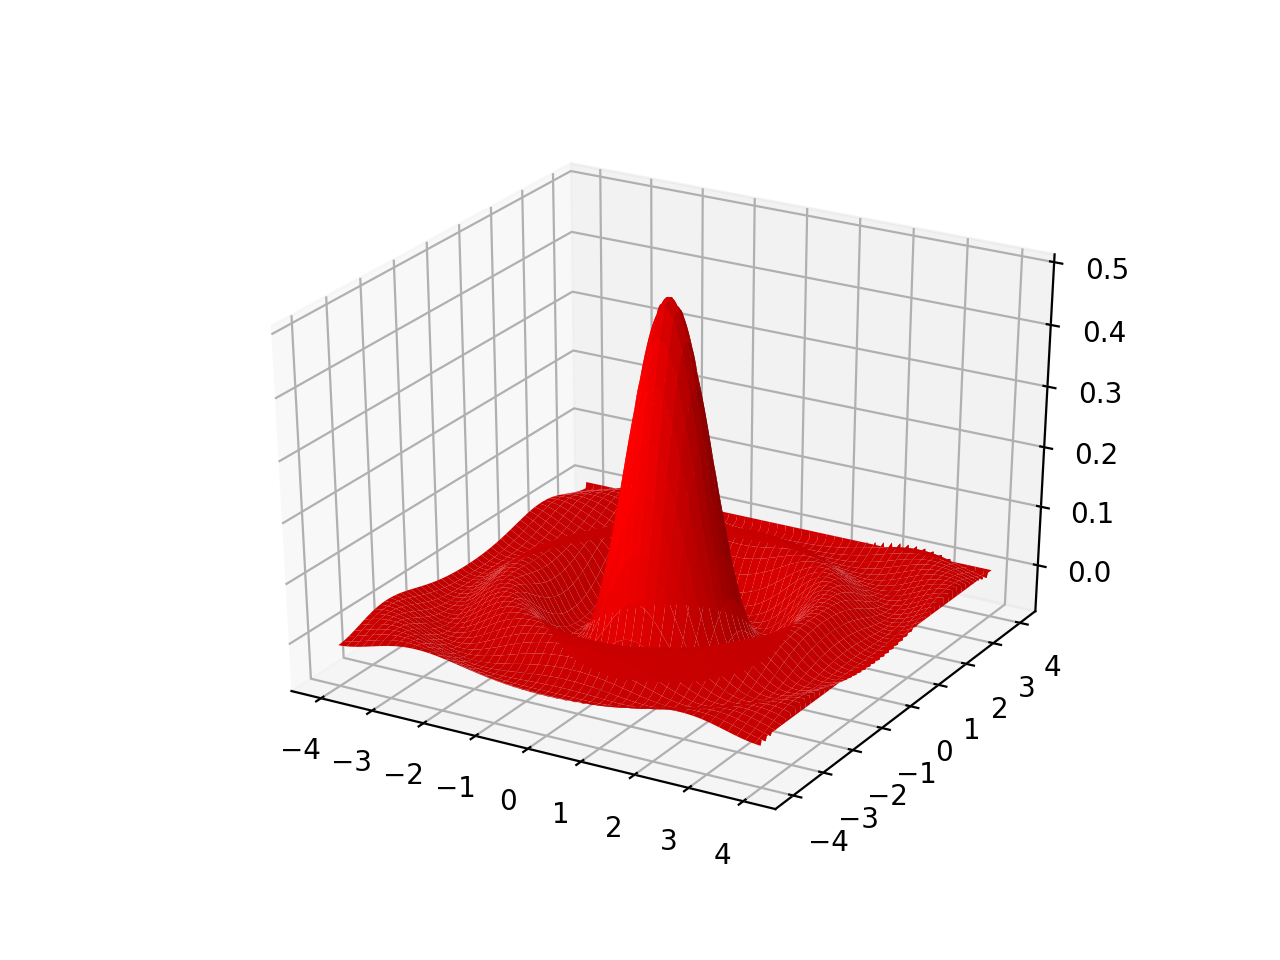

In [711]:
x = np.linspace(-4, 4, 400)
y = np.linspace(-4, 4, 400)
assembled = assemble_tiles(tiles, support, [sp.ev for sp in splines])

(x, y) = np.meshgrid(x, y)
z = assembled(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, color = "red")
plt.show()

<IPython.core.display.Javascript object>


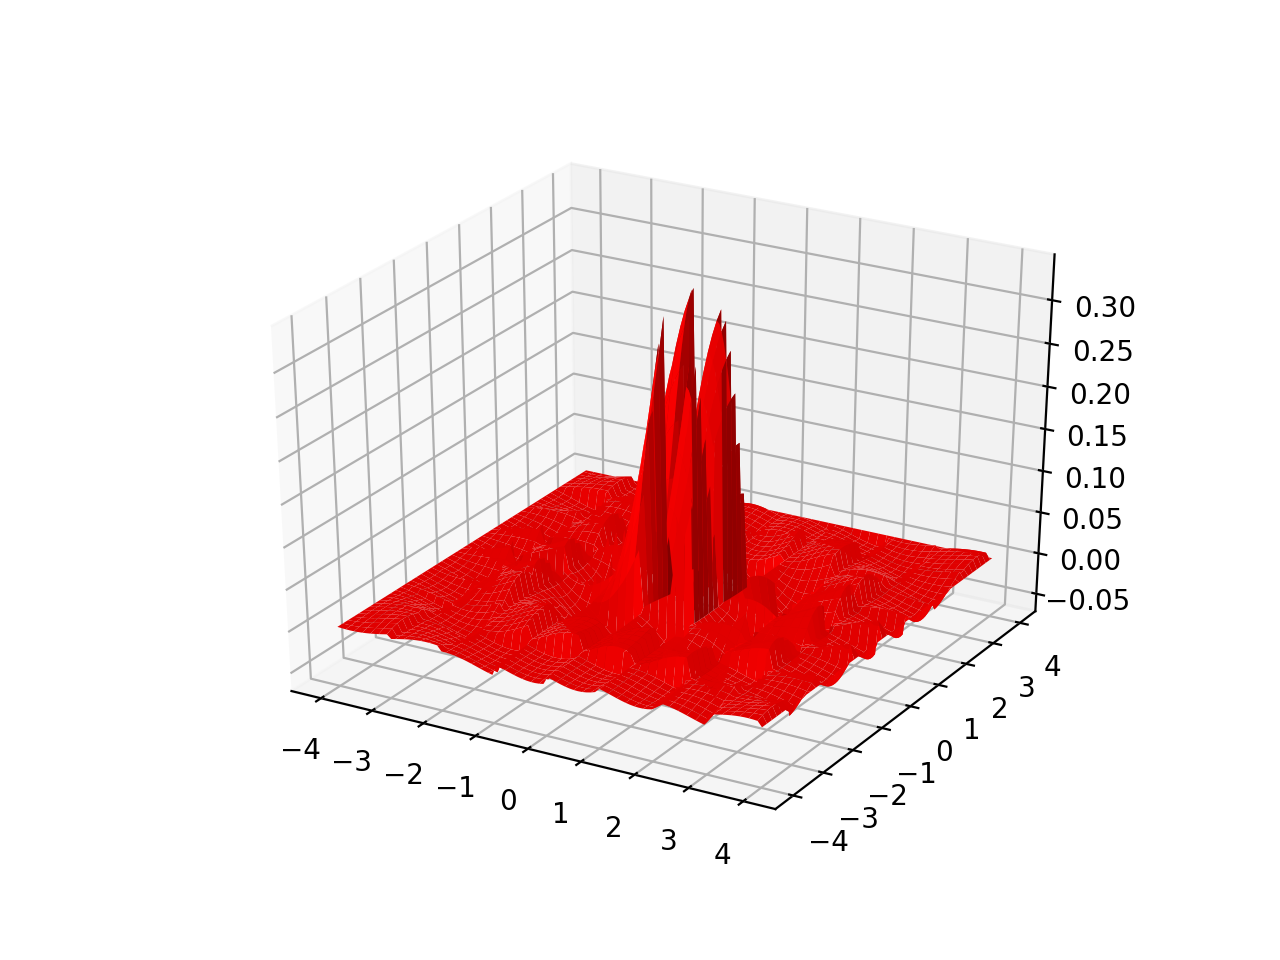

In [708]:
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)

serialized = [sp.serialize(["x","y"]) for sp in int_splines]
funcs = [lambda x,y,ser=ser: eval_serialized(ser, [x,y]) for ser in serialized]

assembled = assemble_tiles(tiles, support, funcs)

(x, y) = np.meshgrid(x, y)
z = assembled(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, color = "red")
plt.show()

## More Exporting

In [712]:
import msgpack
with open(filter_name+'.filter', mode='wb') as f:
    entry = {}
    entry['name'] = filter_name
    entry['support'] = ((-float(support),float(support)), (-float(support),float(support)))
    entry['normalization'] = normalization
    entry['line_tiles'] = [[serde_line_tiles]]
    msgpack.dump(entry, f)

In [713]:
import json
with open(filter_name+'.json', mode='w', encoding='utf-8') as f:
    entry = {}
    entry['name'] = filter_name
    entry['support'] = ((-float(support),float(support)), (-float(support),float(support)))
    entry['normalization'] = normalization
    entry['line_tiles'] = serde_line_tiles
    json.dump(entry, f)

In [707]:
eval_serialized(int_splines[0].serialize(["x","y"]), [[0.5,0.4,0.5], [0.5,0.6,0.6]])

array([0.00556341, 0.00478678, 0.00616593])

In [571]:
int_splines[0].substitute("x", 0.5).substitute("y", 0.5)

(-1.7017710366767841e-06)

In [576]:
a = np.power([[1,2],[3,4]], [2,3])
a

array([[ 1,  8],
       [ 9, 64]])

In [594]:
serialized[3]

[(0.0117712710500426, [4, 3]),
 (0.019516320163056787, [4, 2]),
 (-0.00019006185363222225, [4, 1]),
 (-0.062160678014586246, [4, 0]),
 (-0.052019254546561443, [3, 3]),
 (0.02943988307842027, [3, 2]),
 (-0.0030795112800805859, [3, 1]),
 (0.091516444077208173, [3, 0]),
 (0.033813449923565879, [2, 3]),
 (-0.045792875959600597, [2, 2]),
 (0.003001589040962524, [2, 1]),
 (-0.012953310086639788, [2, 0]),
 (-2.1336025356785112e-18, [1, 3]),
 (5.1079003078294592e-18, [1, 2]),
 (-4.0917888260549509e-18, [1, 1]),
 (4.9416534948400859e-19, [1, 0])]